# Object-Oriented version of Sprinklings

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

Here we define a sprinkling object which hast various methods that we can use to find the properties and copare different individual graphs.<br>
The methods that are identified here are:<br>

- <strong>setSprinkling</strong>: Initializes values of coordinates in a sprinkling
- <strong>getSprinkling</strong>: Returns a set of coordinate values for sprinkling if it is initialized
- <strong>setLinks</strong>: Sets up the link matrix
- <strong>getLinks</strong>: Returns a list object containing the link information
- <strong>setRelations</strong>: Sets up the Relation matrix
- <strong>getRelations</strong>: Returns a list object containing the relation information
- <strong>getPathDistributionProperties</strong>: Returns a tuple with <i><strong> peak position, full width at half maximum, path length distribution</strong></i>.
- <strong>getChainDistributionProperties</strong>: Returns a tuple with <i><strong> peak position, full width at half maximum, chain length distribution</strong></i>.

In [2]:
class Sprinkling():
    '''Sprinkling object from Minkowski Manifold'''
    def __init__(self):
        self.Coords = None
        self.Link = None
        self.Relation = None
        self.LPeak = None
        self.LWidth = None
        self.RPeak = None
        self.RWidth = None
        self.PathDistribution = None
        self.ChainDistribution = None
        self.dimension = 2
        self.Npoints = 100
    def setSprinkling(self, D = 2, N = 100):
        '''Initializing the coordinates of the points in the graph'''
        def future(xf,xp,d):
            R=np.sqrt(sum([(xf[i]-xp[i])**2 for i in range(1,d)]))
            if xp[0]<xf[0] and R< xf[0]-xp[0]:
                return 1
            else:
                return 0
        ##################
        #D represent the dimension
        ###################
        #defining the box that the points are being sprinkled in at random.
        boxdim=[1]*D
        xmin=[0]*D
        xmax=[1]+[0]*(D-1)
        ###################
        points=[xmin]
        while len(points)<N+1:
            point=[np.random.uniform(0,1)]+[np.random.uniform(-1.0/2,1.0/2) for dim in range(1,D)]#a list of length d of random numbers
            if future(xmax,point,D)==1 and future(point,xmin,D)==1:# if it is in the required interval
                points.append(point)
        points.append(xmax)
        self.Coords = points
    def getSprinkling(self):
        '''This method returns the coordinates of the points as a list'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        else:
            return self.Coords
    def setLinks(self):
        '''This method sets up the Link matrix
        Link matrix has the informations regarding the points that are connected together'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        else:
            D = len(self.Coords[0])
            #determining if xf is in the future of xp
            def future(xf,xp,d):
                R=np.sqrt(sum([(xf[i]-xp[i])**2 for i in range(1,d)]))
                if xp[0]<xf[0] and R< xf[0]-xp[0]:
                    return 1
                else:
                    return 0
            #determining if xm is between xp and xf      
            def condition(xf,xm,xp,d):
                if future(xf,xm,d)==1 and future(xm,xp,d)==1:
                    return 0
                else:
                    return 1
            #determining if xf and xp are nearest neighbors
            def empty (xf,xp,L,d):
                count=0
                for i in range(len(L)):
                    if condition(xf,L[i],xp,d)==0:
                        return 0
                if count==0:
                    return 1
            self.Link = [[1 if future(self.Coords[e2], self.Coords[e1], D)==1 and 
                          empty(self.Coords[e2], self.Coords[e1],self.Coords,D) == 1 else 0 
                          for e2 in range(len(self.Coords))]for e1 in range(len(self.Coords))]
    def getLinks(self):
        '''Returns the link matrix as a list object'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        else:
            return self.Link
    def setRelations(self):
        '''This method sets up the Relation matrix
        Relation matrix has the informations regarding the points that are related together'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        else:
            D = len(self.Coords[0])
            #determining if xf is in the future of xp
            def future(xf,xp,d):
                R=np.sqrt(sum([(xf[i]-xp[i])**2 for i in range(1,d)]))
                if xp[0]<xf[0] and R< xf[0]-xp[0]:
                    return 1
                else:
                    return 0
            self.Relation = [[1 if future(self.Coords[e2], self.Coords[e1], D)==1 else 0 
                          for e2 in range(len(self.Coords))]for e1 in range(len(self.Coords))]
    def getRelations(self):
        '''Returns the Relation matrix as a list object'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        else:
            return self.Relation
    def getPathDistributionProperties(self):
        '''Returns the properties of the path length distribution in a tuple.
        The returned values are peak, width, Distribution'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        elif self.Link == None:
            print 'You Should Set the Link matrix First. You can use setLinks method'
        else:
            '''Distribution Finder, Returns Peak, Width, and Distribution'''
            ######################
            N = len(self.Link)-2
            mlinks = sparse.csr_matrix(np.matrix(self.Link), dtype = np.float64)
            zero = sparse.csr_matrix(np.zeros((N+2, N+2)), dtype = np.float64)
            A = sparse.csr_matrix(np.identity(N+2), dtype = np.float64)
            tot = []
            for m in range(1, N+3):
                A=A*mlinks
                tot.append(A[0,-1])
                if (A!=zero).nnz == 0:
                    break
            self.PathDistribution = tot
            totpath=sum(tot)
            ##################################
            #finding the maximum and the width
            peak_idx = tot.index(max(tot))
            peak = peak_idx+1
            half_height = max(tot)/2.0
            low = 0; high = 0
            for i in range(len(tot)-1):
                if tot[i]<=half_height and tot[i+1] > half_height:
                    low = i+1/2.0
                if tot[i+1] <= half_height and tot[i] > half_height:
                    high = i+1/2.0
            half_width = high-low
            self.LPeak = peak
            self.LWidth = half_width
            return peak, half_width, tot
    def getChainDistributionProperties(self):
        '''Returns the properties of the chain length distribution in a tuple.
        The returned values are peak, width, Distribution'''
        if self.Coords == None:
            print 'You Should Set the Sprinkling First. You can use setSprinkling method'
        elif self.Relation == None:
            print 'You Should Set the Relation matrix First. You can use setRelationss method'
        else:
            '''Distribution Finder, Returns Peak, Width, and Distribution'''
            ######################
            N = len(self.Relation)-2
            mlinks = sparse.csr_matrix(np.matrix(self.Relation), dtype = np.float64)
            zero = sparse.csr_matrix(np.zeros((N+2, N+2)), dtype = np.float64)
            A = sparse.csr_matrix(np.identity(N+2), dtype = np.float64)
            tot = []
            for m in range(1, N+3):
                A=A*mlinks
                tot.append(A[0,-1])
                if (A!=zero).nnz == 0:
                    break
            self.ChainDistribution = tot
            totpath=sum(tot)
            ##################################
            #finding the maximum and the width
            peak_idx = tot.index(max(tot))
            peak = peak_idx+1
            half_height = max(tot)/2.0
            low = 0; high = 0
            for i in range(len(tot)-1):
                if tot[i]<=half_height and tot[i+1] > half_height:
                    low = i+1/2.0
                if tot[i+1] <= half_height and tot[i] > half_height:
                    high = i+1/2.0
            half_width = high-low
            self.RPeak = peak
            self.RWidth = half_width
            return peak, half_width, tot

In [3]:
S_P_1 = Sprinkling()
S_P_2 = Sprinkling()

In [4]:
S_P_1.setSprinkling(3, 200)
S_P_2.setSprinkling(3, 200)

In [5]:
S_P_1.setLinks()
S_P_2.setLinks()

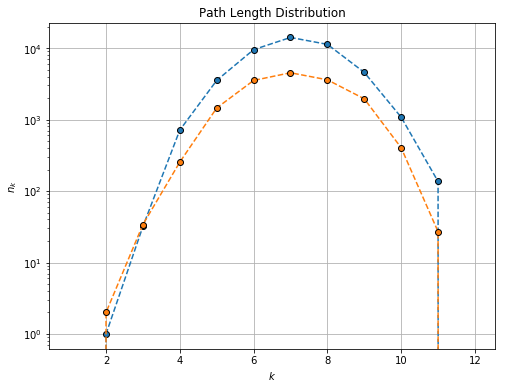

In [6]:
peak_P_1, width_P_1, y_P_1 = S_P_1.getPathDistributionProperties()
peak_P_2, width_P_2, y_P_2 = S_P_2.getPathDistributionProperties()
x_P_1 = range(1, len(y_P_1)+1)
x_P_2 = range(1, len(y_P_2)+1)
plt.figure(figsize = (8, 6))
plt.semilogy(x_P_1, y_P_1, '--o', mec = 'k')
plt.semilogy(x_P_2, y_P_2, '--o', mec = 'k')
plt.title('Path Length Distribution')
plt.xlabel(r'$k$')
plt.ylabel(r'$n_k$')
plt.grid()
plt.show()

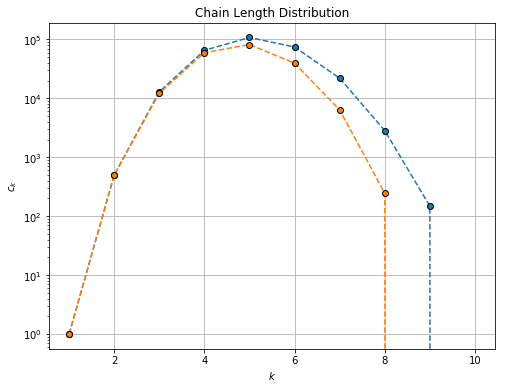

In [7]:
S_C_1 = Sprinkling()
S_C_2 = Sprinkling()
S_C_1.setSprinkling(4, 500)
S_C_2.setSprinkling(4, 500)
S_C_1.setRelations()
S_C_2.setRelations()
peak_C_1, width_C_1, y_C_1 = S_C_1.getChainDistributionProperties()
peak_C_2, width_C_2, y_C_2 = S_C_2.getChainDistributionProperties()
x_C_1 = range(1, len(y_C_1)+1)
x_C_2 = range(1, len(y_C_2)+1)
plt.figure(figsize = (8, 6))
plt.semilogy(x_C_1, y_C_1, '--o', mec = 'k')
plt.semilogy(x_C_2, y_C_2, '--o', mec = 'k')
plt.title('Chain Length Distribution')
plt.xlabel(r'$k$')
plt.ylabel(r'$c_k$')
plt.grid()
plt.show()